In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Train accuracy: 1.0
Test accuracy: 0.8853


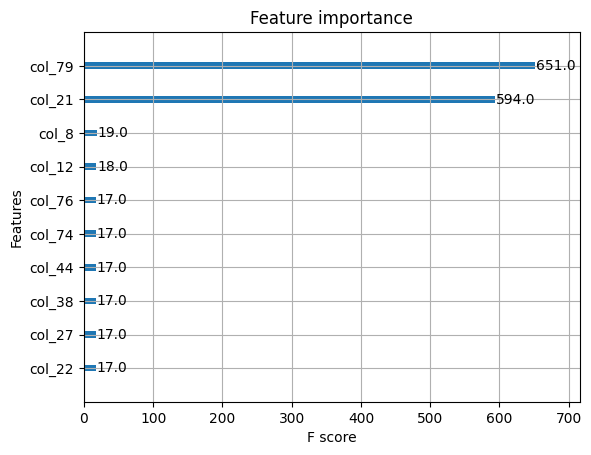

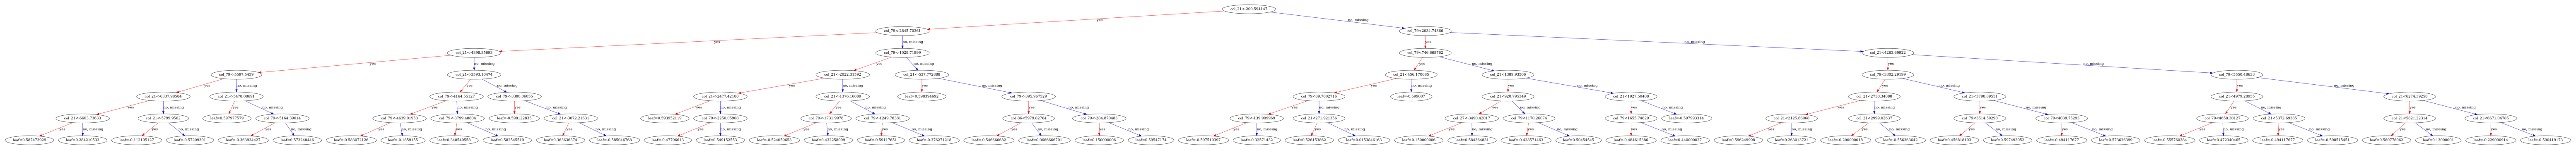

In [20]:
# データの形状を定義
num_rows = 50_000
num_cols = 100

# 列ごとに最大値と最小値の異なるランダムな値を生成
max_vals = np.random.randint(0, 10_000, num_cols)
min_vals = np.random.randint(-10_000, 0, num_cols)

# データを生成
train_data = np.random.rand(num_rows, num_cols) * (max_vals - min_vals) + min_vals
test_data = np.random.rand(num_rows, num_cols) * (max_vals * 4 - min_vals * 4) + min_vals * 4

# 平均値を0にする
train_data -= np.mean(train_data, axis=0)
test_data -= np.mean(test_data, axis=0)

df_train = pd.DataFrame(train_data).add_prefix("col_")
df_test = pd.DataFrame(test_data).add_prefix("col_")

x_1 = np.random.randint(0, num_cols, 1)[0]
x_2 = x_1
while x_2 == x_1:
    x_2 = np.random.randint(0, num_cols, 1)[0]

df_train["target"] = np.where(df_train.iloc[:, x_1] >= df_train.iloc[:, x_2], 1, 0)
df_test["target"] = np.where(df_test.iloc[:, x_1] >= df_test.iloc[:, x_2], 1, 0)

#データを分割
train_X = df_train.iloc[:, :-1]
train_y = df_train.iloc[:, -1]
test_X = df_test.iloc[:, :-1]
test_y = df_test.iloc[:, -1]

# XGBoostの分類器を作成
model = xgb.XGBClassifier(objective='binary:logistic', tree_method='gpu_hist')

# モデルを学習
model.fit(train_X, train_y)
xgb.plot_importance(model, max_num_features=10)
xgb.plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(80, 40)

# 予測
df_train["pred"] = model.predict(train_X)
df_test["pred"] = model.predict(test_X)

# 精度を計算
accuracy = accuracy_score(test_y, df_test["pred"])

print(f"Train accuracy: {accuracy_score(train_y, df_train['pred'])}")
print(f"Test accuracy: {accuracy_score(test_y, df_test['pred'])}")

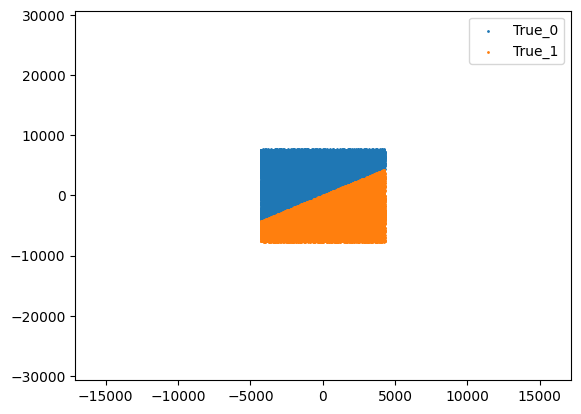

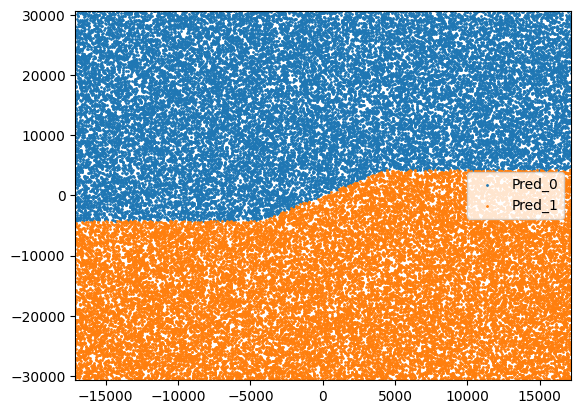

In [4]:
# 結果をプロット
plt.scatter(df_train[df_train["target"] == 0].iloc[:, x_1], df_train[df_train["target"] == 0].iloc[:, x_2], label='True_0', s=1)
plt.scatter(df_train[df_train["target"] == 1].iloc[:, x_1], df_train[df_train["target"] == 1].iloc[:, x_2], label='True_1', s=1)
plt.xlim(df_test.iloc[:, x_1].min(), df_test.iloc[:, x_1].max())
plt.ylim(df_test.iloc[:, x_2].min(), df_test.iloc[:, x_2].max())
plt.legend()
plt.show()

plt.scatter(df_test[df_test["pred"] == 0].iloc[:, x_1], df_test[df_test["pred"] == 0].iloc[:, x_2], label='Pred_0', s=1)
plt.scatter(df_test[df_test["pred"] == 1].iloc[:, x_1], df_test[df_test["pred"] == 1].iloc[:, x_2], label='Pred_1', s=1)
plt.xlim(df_test.iloc[:, x_1].min(), df_test.iloc[:, x_1].max())
plt.ylim(df_test.iloc[:, x_2].min(), df_test.iloc[:, x_2].max())
plt.legend()
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(100, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model and optimizer
model = DNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the data
train_X_tensor = torch.tensor(train_X.values).float()
train_y_tensor = torch.tensor(train_y.values).long()
test_X_tensor = torch.tensor(test_X.values).float()
test_y_tensor = torch.tensor(test_y.values).long()

# Train the model
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(train_X_tensor)
    loss = nn.CrossEntropyLoss()(output, train_y_tensor)
    loss.backward()
    optimizer.step()

# Evaluate the model
with torch.no_grad():
    # First output with training
    output = model(train_X_tensor)
    _, predicted = torch.max(output.data, 1)
    df_train["pred"] = predicted
    train_accuracy = (predicted == train_y_tensor).sum().item() / len(train_y_tensor)
    
    output = model(test_X_tensor)
    _, predicted = torch.max(output.data, 1)
    df_test["pred"] = predicted
    test_accuracy = (predicted == test_y_tensor).sum().item() / len(test_y_tensor)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 1.0
Test accuracy: 0.9347


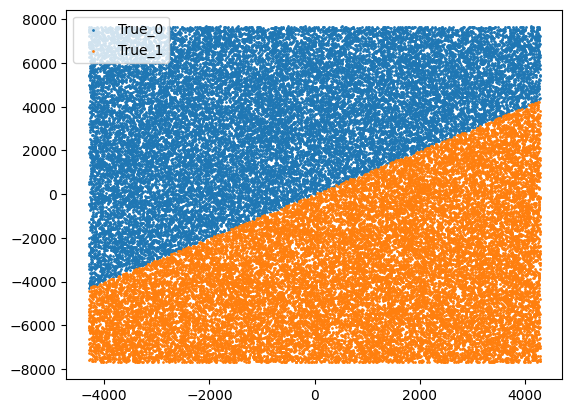

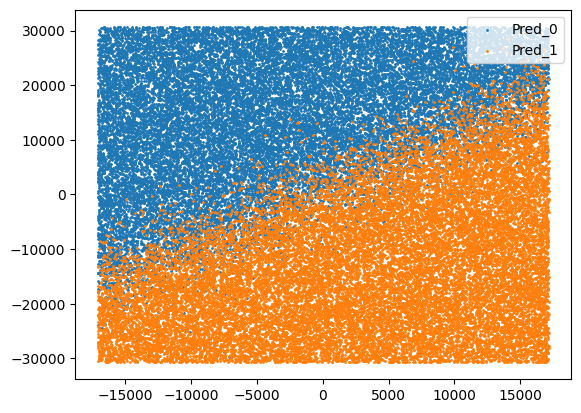

In [9]:
# 結果をプロット
plt.scatter(df_train[df_train["pred"] == 0].iloc[:, x_1], df_train[df_train["pred"] == 0].iloc[:, x_2], label='True_0', s=1)
plt.scatter(df_train[df_train["pred"] == 1].iloc[:, x_1], df_train[df_train["pred"] == 1].iloc[:, x_2], label='True_1', s=1)
plt.legend()
plt.show()

plt.scatter(df_test[df_test["pred"] == 0].iloc[:, x_1], df_test[df_test["pred"] == 0].iloc[:, x_2], label='Pred_0', s=1)
plt.scatter(df_test[df_test["pred"] == 1].iloc[:, x_1], df_test[df_test["pred"] == 1].iloc[:, x_2], label='Pred_1', s=1)
plt.legend()
plt.show()